## feature extraction

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
base_dir = 'data/KDEF_and_AKDEF/KDEF/'

In [3]:
import os
# 显示几个随机增强后的训练图像
from keras.preprocessing import image 

In [4]:
# 将文件名读入list中
def read(filename):
    data = []
    file = open(filename, 'r')
    for line in file:
        data.append(line.replace('\n',''))
    file.close()
    return data

In [5]:
training_data = read('data/train.txt')
test_data = read('data/test.txt')
validation_data = read('data/validation.txt')

In [6]:
len(training_data), len(test_data), len(validation_data)

(2900, 1000, 1000)

In [7]:
import numpy as np
# 从文本中提取数据出来
def process(data):
    path = [item.split(',')[0] for item in data]
    expression = [int(item.split(',')[1]) for item in data]
    angle = [int(item.split(',')[2]) for item in data]
    return path, expression, angle

# one-hot 编码
def to_one_hot(labels, dimension=1):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [8]:
training_path, training_expression, training_angle = process(training_data)
test_path, test_expression, test_angle = process(test_data)
validation_path, validation_expression, validation_angle = process(validation_data)

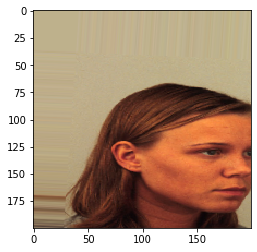

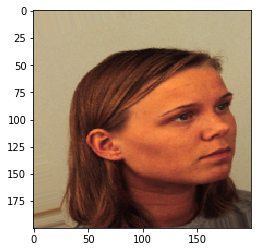

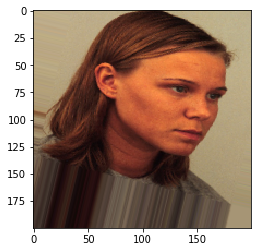

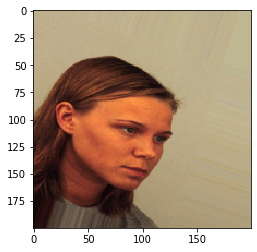

In [9]:
# 可视化data augmentation图片
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')


img = image.load_img(base_dir + training_path[0], target_size=(200, 200)) # 读取图像并调整大小

x = image.img_to_array(img) # 将其转化为(img.size[0], img.size[1], 3)的Numpy数组

x = x.reshape((1,) + x.shape) # 将其转化为(1, img.size[0], img.size[1], 3)的Numpy

import matplotlib.pyplot as plt

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot=plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()
    

In [10]:
# 将数据分放
data_dir = 'data/'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

label_range = np.unique(training_expression)

# training data dictionary
train_dir = os.path.join(data_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    for i in label_range:
        train_i_dir = os.path.join(train_dir, str(i))
        if not os.path.exists(train_i_dir):
            os.mkdir(train_i_dir)
            
# test data dictionary
test_dir = os.path.join(data_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
    for i in label_range:
        test_i_dir = os.path.join(test_dir, str(i))
        if not os.path.exists(test_i_dir):
            os.mkdir(test_i_dir)
            
# validation data dictionary
validation_dir = os.path.join(data_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
    for i in label_range:
        validation_i_dir = os.path.join(validation_dir, str(i))
        if not os.path.exists(validation_i_dir):
            os.mkdir(validation_i_dir)

In [11]:
# copy file to the dictionary
import shutil

# training data copy
for path, expression in zip(training_path, training_expression):
    file = path.split('/')[1]
    src = os.path.join(base_dir, path)
    dst = os.path.join(train_dir, str(expression), file)
    shutil.copyfile(src, dst)

# test data copy
for path, expression in zip(test_path, test_expression):
    file = path.split('/')[1]
    src = os.path.join(base_dir, path)
    dst = os.path.join(test_dir, str(expression), file)
    shutil.copyfile(src, dst)
    
for path, expression in zip(validation_path, validation_expression):
    file = path.split('/')[1]
    src = os.path.join(base_dir, path)
    dst = os.path.join(validation_dir, str(expression), file)
    shutil.copyfile(src, dst)

In [27]:
# 引入预训练模型
from keras.applications import  ResNet50
conv_base = ResNet50(include_top=False, 
                     weights='imagenet',
                     input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 6s 0us/step


In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
train_dir

'data/train'

In [31]:
from tqdm import tqdm
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in tqdm(generator):
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            #注意，这些生成器在循环中不断生成数据，所以你必须在读取完所有图像后终止循环
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2900)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)




  0%|          | 0/145 [00:00<?, ?it/s]

Found 2900 images belonging to 7 classes.





  1%|          | 1/145 [00:00<00:47,  3.02it/s]


  1%|▏         | 2/145 [00:00<00:47,  3.02it/s]


  2%|▏         | 3/145 [00:01<00:47,  2.96it/s]


  3%|▎         | 4/145 [00:01<00:47,  2.97it/s]


  3%|▎         | 5/145 [00:01<00:47,  2.98it/s]


  4%|▍         | 6/145 [00:02<00:46,  2.98it/s]


  5%|▍         | 7/145 [00:02<00:46,  2.99it/s]


  6%|▌         | 8/145 [00:02<00:45,  3.01it/s]


  6%|▌         | 9/145 [00:03<00:45,  3.01it/s]


  7%|▋         | 10/145 [00:03<00:44,  3.00it/s]


  8%|▊         | 11/145 [00:03<00:44,  3.01it/s]


  8%|▊         | 12/145 [00:04<00:44,  3.02it/s]


  9%|▉         | 13/145 [00:04<00:43,  3.02it/s]


 10%|▉         | 14/145 [00:04<00:43,  3.02it/s]


 10%|█         | 15/145 [00:04<00:43,  3.02it/s]


 11%|█         | 16/145 [00:05<00:42,  3.02it/s]


 12%|█▏        | 17/145 [00:05<00:43,  2.94it/s]


 12%|█▏        | 18/145 [00:06<00:42,  2.97it/s]


 13%|█▎        | 19/145 [00:06<00:42,  2.99it/s]


 14%|█▍        | 20/145 [00:06<00:41,

 94%|█████████▍| 137/145 [00:45<00:02,  3.00it/s]


 95%|█████████▌| 138/145 [00:46<00:02,  2.93it/s]


 96%|█████████▌| 139/145 [00:46<00:02,  2.94it/s]


 97%|█████████▋| 140/145 [00:46<00:01,  2.95it/s]


 97%|█████████▋| 141/145 [00:47<00:01,  2.97it/s]


 98%|█████████▊| 142/145 [00:47<00:01,  2.97it/s]


 99%|█████████▊| 143/145 [00:47<00:00,  2.99it/s]


 99%|█████████▉| 144/145 [00:48<00:00,  2.98it/s]



  0%|          | 0/50 [00:00<?, ?it/s]

Found 1000 images belonging to 7 classes.






  2%|▏         | 1/50 [00:00<00:17,  2.77it/s]



  4%|▍         | 2/50 [00:00<00:16,  2.84it/s]



  6%|▌         | 3/50 [00:01<00:16,  2.89it/s]



  8%|▊         | 4/50 [00:01<00:15,  2.92it/s]



 10%|█         | 5/50 [00:01<00:15,  2.96it/s]



 12%|█▏        | 6/50 [00:02<00:14,  2.96it/s]



 14%|█▍        | 7/50 [00:02<00:14,  2.96it/s]



 16%|█▌        | 8/50 [00:02<00:14,  2.98it/s]



 18%|█▊        | 9/50 [00:03<00:13,  2.99it/s]



 20%|██        | 10/50 [00:03<00:13,  2.98it/s]



 22%|██▏       | 11/50 [00:03<00:13,  3.00it/s]



 24%|██▍       | 12/50 [00:04<00:12,  2.99it/s]



 26%|██▌       | 13/50 [00:04<00:12,  2.99it/s]



 28%|██▊       | 14/50 [00:04<00:12,  2.99it/s]



 30%|███       | 15/50 [00:05<00:11,  3.00it/s]



 32%|███▏      | 16/50 [00:05<00:11,  3.00it/s]



 34%|███▍      | 17/50 [00:05<00:10,  3.02it/s]



 36%|███▌      | 18/50 [00:06<00:10,  3.02it/s]



 38%|███▊      | 19/50 [00:06<00:10,  3.00it/s]



 40%|████      | 20/50 [00:06<00:09,

Found 1000 images belonging to 7 classes.







  2%|▏         | 1/50 [00:00<00:17,  2.75it/s]




  4%|▍         | 2/50 [00:00<00:17,  2.82it/s]




  6%|▌         | 3/50 [00:01<00:16,  2.79it/s]




  8%|▊         | 4/50 [00:01<00:16,  2.85it/s]




 10%|█         | 5/50 [00:01<00:15,  2.88it/s]




 12%|█▏        | 6/50 [00:02<00:15,  2.92it/s]




 14%|█▍        | 7/50 [00:02<00:14,  2.95it/s]




 16%|█▌        | 8/50 [00:02<00:14,  2.96it/s]




 18%|█▊        | 9/50 [00:03<00:13,  2.97it/s]




 20%|██        | 10/50 [00:03<00:13,  2.99it/s]




 22%|██▏       | 11/50 [00:03<00:13,  2.98it/s]




 24%|██▍       | 12/50 [00:04<00:12,  3.00it/s]




 26%|██▌       | 13/50 [00:04<00:12,  3.00it/s]




 28%|██▊       | 14/50 [00:04<00:12,  2.99it/s]




 30%|███       | 15/50 [00:05<00:11,  2.99it/s]




 32%|███▏      | 16/50 [00:05<00:11,  3.00it/s]




 34%|███▍      | 17/50 [00:05<00:10,  3.00it/s]




 36%|███▌      | 18/50 [00:06<00:10,  2.94it/s]




 38%|███▊      | 19/50 [00:06<00:10,  2.97it/s]




 40%|████      |

In [32]:
train_features.shape, train_labels

((2900, 7, 7, 512), array([0., 6., 4., ..., 2., 3., 4.]))

In [33]:
train_features = np.reshape(train_features, (2900, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (1000, 7 * 7 * 512))
test_features = np.reshape(test_features, (1000, 7 * 7 * 512))

In [34]:
# one_hot 编码
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)
one_hot_validation_labels = to_categorical(validation_labels)

In [35]:
np.bincount(np.array(validation_labels, dtype='int64'))

array([137, 155, 143, 141, 138, 141, 145])

In [37]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, one_hot_train_labels,
                    epochs=50,
                    batch_size=40,
                    validation_data=(validation_features, one_hot_validation_labels))

Train on 2900 samples, validate on 1000 samples
Epoch 1/50
2900/2900 [==============================] - 1s 262us/step - loss: 0.7938 - acc: 0.7961 - val_loss: 0.4332 - val_acc: 0.8571
Epoch 2/50
2900/2900 [==============================] - 1s 223us/step - loss: 0.4897 - acc: 0.8277 - val_loss: 0.4179 - val_acc: 0.8571
Epoch 3/50
2900/2900 [==============================] - 1s 225us/step - loss: 0.4698 - acc: 0.8471 - val_loss: 0.4159 - val_acc: 0.8571
Epoch 4/50
2900/2900 [==============================] - 1s 226us/step - loss: 0.4549 - acc: 0.8537 - val_loss: 0.4137 - val_acc: 0.8571
Epoch 5/50
2900/2900 [==============================] - 1s 228us/step - loss: 0.4453 - acc: 0.8529 - val_loss: 0.4005 - val_acc: 0.8574
Epoch 6/50
2900/2900 [==============================] - 1s 226us/step - loss: 0.4367 - acc: 0.8540 - val_loss: 0.4011 - val_acc: 0.8587
Epoch 7/50
2900/2900 [==============================] - 1s 221us/step - loss: 0.4294 - acc: 0.8553 - val_loss: 0.4099 - val_acc: 0.8594


In [38]:
result = model.evaluate(test_features, one_hot_test_labels)

1000/1000 [==============================] - 0s 102us/step


In [39]:
result

[0.5482526655197144, 0.8528570532798767]

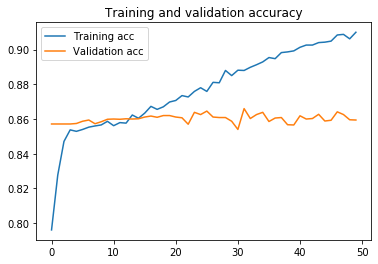

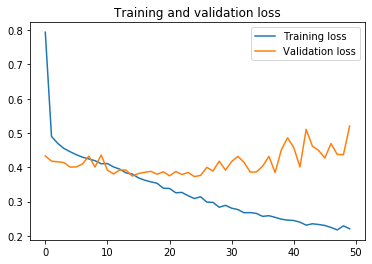

In [40]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## fine-tuning

In [41]:
from keras import models
from keras import layers

model = models.Sequential() # 產生一個新的網絡模型結構
model.add(conv_base)        # 把預訓練的卷積基底疊上去
model.add(layers.Flatten()) # 打平
model.add(layers.Dense(256, activation='relu'))  # 疊上新的密集連接層來做為分類器
model.add(layers.Dense(7, activation='sigmoid')) # 因為我的資料集只有兩類(cat & dog)

In [42]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_16 (Dense)             (None, 7)                 1799      
Total params: 21,139,271
Trainable params: 21,139,271
Non-trainable params: 0
_________________________________________________________________


In [43]:
# 看一下“凍結前”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [44]:
# “凍結”卷積基底
conv_base.trainable = False

In [45]:
# 再看一下“凍結後”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [49]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 請注意: 驗證用的資料不要進行資料的增強
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 圖像資料的目錄
        train_dir,
        # 設定圖像的高(height)與寬(width)
        target_size=(224, 224),
        batch_size=20)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,)

Found 2900 images belonging to 7 classes.
Found 1000 images belonging to 7 classes.
Epoch 1/30
100/100 [==============================] - 30s 304ms/step - loss: 0.3819 - acc: 0.8587 - val_loss: 0.3975 - val_acc: 0.8610
Epoch 2/30
100/100 [==============================] - 28s 277ms/step - loss: 0.3804 - acc: 0.8591 - val_loss: 0.3724 - val_acc: 0.8621
Epoch 3/30
100/100 [==============================] - 28s 278ms/step - loss: 0.3761 - acc: 0.8597 - val_loss: 0.3980 - val_acc: 0.8616
Epoch 4/30
100/100 [==============================] - 28s 279ms/step - loss: 0.3721 - acc: 0.8606 - val_loss: 0.3998 - val_acc: 0.8650
Epoch 5/30
100/100 [==============================] - 29s 286ms/step - loss: 0.3677 - acc: 0.8594 - val_loss: 0.3407 - val_acc: 0.8641
Epoch 6/30
100/100 [==============================] - 28s 281ms/step - loss: 0.3706 - acc: 0.8604 - val_loss: 0.3622 - val_acc: 0.8654
Epoch 7/30
100/100 [==============================] - 28s 280ms/step - loss: 0.3667 - acc: 0.8605 - val_lo

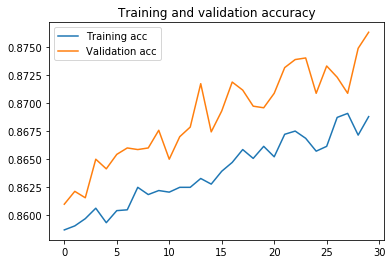

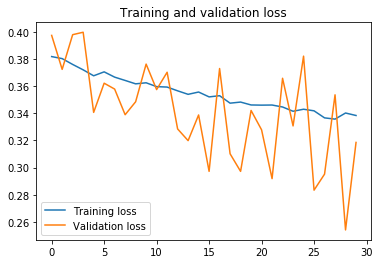

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()